# Explore the Vulnerability database

The following notebook provides a set of functions to navigate through the most extensive list of vulnerability and fragility curves compiled for Critical Infrastructure as part of the MIRACA project.

This notebook is organised in four sections:
- Step 1: Analysis of asset Vulnerability curves

- Step 2: Hazard Vulnerability Modeling

- Example 1: Earthquake vulnerability curve for Education and Health

- Example 2: Windstorm vulnerability curve for Energy

In [37]:
# HIDE CODE
# Import necessary libraries
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import matplotlib.ticker as ticker
import matplotlib as mpl  
from matplotlib import rcParams
from scipy.stats import lognorm
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import re
from pathlib import Path
import data_utils

In [38]:
# Detect project root (the folder containing the notebook)
project_root = Path().resolve().parent
print("Project root:", project_root)

# Define data and results folders
data_path = project_root / "data"
results_path = project_root / "results"

# Create folders if they do not exist
data_path.mkdir(exist_ok=True)
results_path.mkdir(exist_ok=True)

print("Data folder:", data_path)
print("Results folder:", results_path)


# Define paths to the MIRACA vulnerability tables

file_D1 = data_path / "Table_D1_Summary_CI_Vulnerability_Data_V2.0.0_AUTH.xlsx"
file_D2 = data_path / "Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V2.0.0_AUTH.xlsx"
file_D3 = data_path / "Table_D3_Costs_V2.0.0_AUTH.xlsx"

Project root: /Users/curricelqui/0_AREA/02_Projects/MIRACA/code/miraca-book/miraca-book/background/Vulnerability
Data folder: /Users/curricelqui/0_AREA/02_Projects/MIRACA/code/miraca-book/miraca-book/background/Vulnerability/data
Results folder: /Users/curricelqui/0_AREA/02_Projects/MIRACA/code/miraca-book/miraca-book/background/Vulnerability/results


In [39]:
# Set-up the MIRACA color palette, containing all hex colour codes used for consistent styling in plots and visual outputs.
colors = {
    "primary_blue_500": "#4069F6",
    "red": "#ED5861",
    "grey_600": "#7B7F8F",
    "yellow": "#FBC40B",
    "blue_100": "#E0E7FE",
    "green_500": "#64F4C0",
    "green_500": "#64F4C0",
    "white": "#FFFFFF",
    "black": "#1F1E37",
}

## Step 1: Analysis of asset Vulnerability curves

In this section we provide a summary of the different curves available. The vulnerability database is analysed and events are categorized based on the MIRACA Taxonomy. It calculates the distribution of vulnerability functions by Critical Infrastucture and Hazard Type.


The `hazard_mapping` dictionary below provides the 10 hazard codes used in the MIRACA vulnerability sheets. These can be used to search for hazard-specific vulnerability curves, ensuring a consistent interpretation across sectors and analyses.

The `networks` dictionary provides a list with the typology of Critical Infrastructure sectors that can be explored.

In [40]:
# === Hazard mapping dictionary ===
hazard_mapping = {
    'E': 'Earthquakes',
    'F': 'Floods',
    'L': 'Landslides',
    'W': 'Windstorms',  # Updated for Windstorms
    'WF': 'Wildfires',  # Updated for Wildfires
    'E+L': 'Earthquakes + Landslides',
    'E+F': 'Earthquakes + Floods',
    'E+Liq': 'Earthquakes + Liquefaction',
    'E+W': 'Earthquakes + Windstorms',  # Corrected mapping
    'Multi-Hazard': 'Multi-Hazard'
}

# === Infrastucture mapping dictionary ===
networks = ['Energy',
           'Transportation',
           'Telecommunication',
           'Water',
          ' Waste',
           'Education & Health',
          ] 


# === Intensity mapping dictionary ===
intensity_mapping = {
    "Peak Ground Acceleration": ("PGA", "[g]"),
    "Peak Ground Velocity": ("PGV", "[cm/s]"),
    "Bedrock Peak Ground Velocity": ("PGV", "[cm/s]"),
    "Spectral acceleration": ("Sa", "[g]"),
    "Spectral acceleration (Sa (T1))": ("Sa", "[g]"),
    "Elastic spectral displacement": ("Sd", "[cm]"),
    "3s gust wind speed at 10 m height": ("V10m", "[m/s]"),
    "3-s gust wind speed ": ("V10m", "[m/s]"),
    "Wind speed": ("V10m", "[m/s]"),
    "Permanent ground displacement": ("PGD", "[cm]"),
    "Peak Ground Displacement": ("PGD", "[cm]"),
    "Inundation": ("Depth", "[m]"),
    "fire intensity measure (in min) ": ("FIM", "[min]"),
    "Free field Peak Ground Velocity and Permanent Ground displacement ": ("PGV&PGD", "[cm/s]"),
    "Inundation+Duration": ("Depth&Duration", "[m]"),
    "Rainfall intensity and duration": ("Rainfall inten&durat", "[days]"),
    "3-sec peak gust wind speed at 10 m height": ("V10m", "[m/s]"),
}

To explore the database, the total number of curves per asset is calculated.

In [41]:
# Workbook handler
xls = pd.ExcelFile(file_D1)

In [42]:
asset_counts = {}

for sheet_name in xls.sheet_names:
    df_sheet = pd.read_excel(file_D1, sheet_name=sheet_name, header=1)

    # Identify ID column → only asset sheets have curves
    id_cols = [col for col in df_sheet.columns if 'id number' in col.lower()]
    if not id_cols:
        continue

    id_col = id_cols[0]
    asset_counts[sheet_name] = df_sheet[id_col].nunique()

# Convert to DataFrame
asset_counts_df = pd.DataFrame.from_dict(asset_counts, orient='index', columns=['Total Curves'])

print("Total Number of Curves per asset:")
display(asset_counts_df)

# Save total curves per asset
asset_counts_df.to_csv(results_path / "Total_curves_per_asset.csv", index=True)

Total Number of Curves per asset:


,Total Curves
Energy,446
Transportation,398
Telecommunication,27
Water,147
Waste,98
Education & Health,213


Now, the total number of curves per hazard.

In [43]:
hazard_counts = {}

for sheet_name in xls.sheet_names:
    df_sheet = pd.read_excel(file_D1, sheet_name=sheet_name, header=1)

    # Detect ID column → skip non-asset sheets
    id_cols = [col for col in df_sheet.columns if 'id number' in col.lower()]
    if not id_cols:
        continue
    id_col = id_cols[0]

    # Detect hazard column
    hazard_cols = [col for col in df_sheet.columns if 'hazard' in col.lower()]
    if not hazard_cols:
        continue
    hazard_col = hazard_cols[0]

    # Clean hazard labels
    df_sheet[hazard_col] = df_sheet[hazard_col].astype(str).str.strip().str.upper()

    # Remove invalid hazard labels
    df_sheet = df_sheet[
        df_sheet[hazard_col].notna() &
        (df_sheet[hazard_col] != "") &
        (~df_sheet[hazard_col].isin(["NAN", "NONE", "NA", "N/A"]))
    ]

    # Group combined hazards as Multi-hazard
    df_sheet[hazard_col] = df_sheet[hazard_col].apply(
        lambda x: "Multi-hazard" if "+" in x else x
    )

    # Count curves per hazard
    grouped = df_sheet.groupby(hazard_col)[id_col].nunique()

    # Add to global totals, converting codes to full names
    for hazard, count in grouped.items():
        full_name = hazard_mapping.get(hazard, hazard)
        hazard_counts[full_name] = hazard_counts.get(full_name, 0) + count

# Convert to DataFrame
hazard_counts_df = pd.DataFrame.from_dict(
    hazard_counts, orient='index', columns=['Total Curves']
)

print("\nTotal Number of Curves per Hazard:")
display(hazard_counts_df)

# Save total curves per hazard
hazard_counts_df.to_csv(results_path / "Total_curves_per_hazard.csv", index=True)


Total Number of Curves per Hazard:


,Total Curves
Earthquakes,762
Floods,111
Landslides,147
Multi-hazard,47
Windstorms,254
Wildfires,8


A detailed summary table with the total vulnerability curves per asset is shown.

In [44]:
# Dictionary to store summary per asset
asset_summary = {}

for sheet_name in xls.sheet_names:
    
    # Read sheet (header row 1)
    df_sheet = pd.read_excel(file_D1, sheet_name=sheet_name, header=1)

    # ---- Detect ID column (only sheets with assets have ID numbers) ----
    id_cols = [col for col in df_sheet.columns if 'id number' in col.lower()]
    if not id_cols:
        continue  # skip non-asset sheets

    id_col = id_cols[0]

    # ---- Count total number of curves ----
    total_curves = df_sheet[id_col].nunique()

    # ---- Detect curve type column ----
    curve_type_cols = [col for col in df_sheet.columns if 'fragility' in col.lower()]
    if curve_type_cols:
        curve_type_col = curve_type_cols[0]
        curve_type_counts = df_sheet[curve_type_col].value_counts(dropna=True)
        curve_types = ", ".join(curve_type_counts.index.astype(str))
        curve_type_counts_str = ", ".join([f"{k}: {v}" for k, v in curve_type_counts.items()])
    else:
        curve_type_col = None
        curve_types = ""
        curve_type_counts_str = ""

    # ---- Detect hazard type column ----
    hazard_cols = [col for col in df_sheet.columns if 'hazard' in col.lower()]
    if hazard_cols:
        hazard_col = hazard_cols[0]
        hazard_counts = df_sheet[hazard_col].value_counts(dropna=True)
        hazard_types = ", ".join(hazard_counts.index.astype(str))
        hazard_counts_str = ", ".join([f"{k}: {v}" for k, v in hazard_counts.items()])
    else:
        hazard_col = None
        hazard_types = ""
        hazard_counts_str = ""

    # ---- Store summary ----
    asset_summary[sheet_name] = {
        "Total Curves": total_curves,
        "Curve Types": curve_types,
        "Count per Curve Type": curve_type_counts_str,
        "Hazard Types": hazard_types,
        "Count per Hazard Type": hazard_counts_str,
    }


# Convert dictionary to DataFrame
summary_df = pd.DataFrame.from_dict(asset_summary, orient='index')


# === Curve Type Summary Table ===

curve_type_table = summary_df[[
    "Total Curves",
    "Curve Types",
    "Count per Curve Type"
]]

print("Curve Type Summary:")
display(curve_type_table)

# Save file
curve_type_table.to_csv(results_path / "Curve_type_summary.csv")

# === Hazard Type Summary Table ===

hazard_type_table = summary_df[[
    "Total Curves",
    "Hazard Types",
    "Count per Hazard Type"
]]

print("Detailed Hazard Summary:")
display(hazard_type_table)

# Save file
hazard_type_table.to_csv(results_path / "Hazard_type_summary.csv")

Curve Type Summary:


,Total Curves,Curve Types,Count per Curve Type
Energy,446,"F, F + V, V","F: 348, F + V: 72, V: 26"
Transportation,398,"F, V, F + V, V (repair rate)","F: 306, V: 69, F + V: 22, V (repair rate): 1"
Telecommunication,27,"F, V, F + V","F: 23, V: 2, F + V: 2"
Water,147,"V (repair rate), F, V, F + V","V (repair rate): 57, F: 45, V: 25, F + V: 20"
Waste,98,"V (faults/km), V (repair rate), V, F + V, F","V (faults/km): 36, V (repair rate): 31, V: 14, F + V: 12, F: 5"
Education & Health,213,"F, F + V, V, F + V (3D)","F: 119, F + V: 65, V: 25, F + V (3D): 5"


Detailed Hazard Summary:


,Total Curves,Hazard Types,Count per Hazard Type
Energy,446,"E, W, F, E+W, L","E: 209, W: 203, F: 16, E+W: 12, L: 6"
Transportation,398,"E, L, F, E+F, W","E: 283, L: 65, F: 32, E+F: 16, W: 2"
Telecommunication,27,"W, E, F, L","W: 21, E: 3, F: 2, L: 1"
Water,147,"E, L, F, W","E: 81, L: 39, F: 25, W: 2"
Waste,98,"E, L, F, W","E: 56, L: 26, F: 14, W: 2"
Education & Health,213,"E, W, F, E+F, L, WF, E+Liq, E , E+L","E: 131, W: 24, F: 22, E+F: 14, L: 11, WF: 8, E+Liq: 4, E : 1, E+L: 1"


Finally, the statistic plots with the summary of the database per Critical Infrastucture and per Hazard Type are generated to explore the distribution of the data.

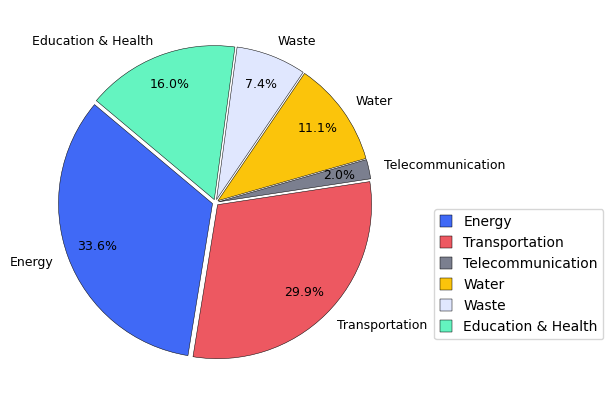

In [45]:
# Get MIRACA colors in the exact order defined in the dictionary
miraca_color_list = list(colors.values())

# Number of assets
n_assets = len(asset_counts_df)

# Take only the first n colors
color_list = miraca_color_list[:n_assets]

# Extract data
asset_counts_series = asset_counts_df["Total Curves"]


explode_value = 0.02
explode = [explode_value] * len(hazard_counts_df["Total Curves"])

fig, ax = plt.subplots(figsize=(6, 5))

wedges, texts, autotexts = ax.pie(
    asset_counts_series,
    labels=asset_counts_series.index,
    autopct='%1.1f%%',
    colors=color_list,
    explode=explode,          
    startangle=140,
    pctdistance=0.8,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.35}
)

# Text styling
for t in texts:
    t.set_fontsize(9)
for a in autotexts:
    a.set_fontsize(9)
    a.set_color("black")



# Legend
ax.legend(
    loc='best',
    bbox_to_anchor=(1.05, 0.5),
    markerscale=0.8,
    handlelength=0.9,
    handleheight=0.9,
    fontsize=10
)

# Save figure
plt.savefig(results_path / "Asset_Distribution.png",
            dpi=400, bbox_inches='tight')

plt.show()


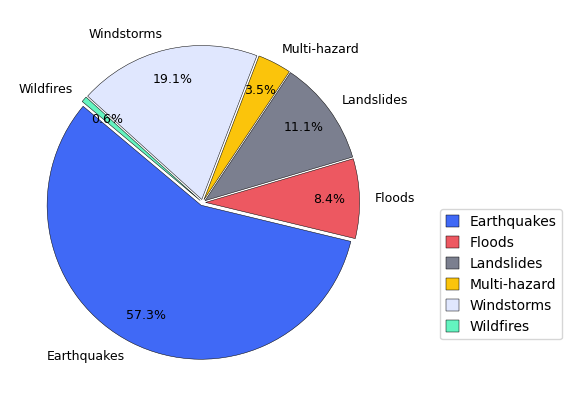

In [46]:
# === PIE CHART: Hazard Distribution using MIRACA Colors (explode all) ===

# Extract hazard data from your earlier summary
hazard_series = hazard_counts_df["Total Curves"]

# MIRACA colors in the exact order defined in the dictionary
miraca_color_list = list(colors.values())

# Match number of colors to number of hazard categories
color_list = miraca_color_list[:len(hazard_series)]

# Explode all slices equally
explode_value = 0.02
explode = [explode_value] * len(hazard_series)

fig, ax = plt.subplots(figsize=(6, 5))

wedges, texts, autotexts = ax.pie(
    hazard_series,
    labels=hazard_series.index,      # already has full names e.g. "Earthquakes"
    autopct='%1.1f%%',
    colors=color_list,
    explode=explode,
    startangle=140,
    pctdistance=0.8,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.35}
)

# Text styling
for t in texts:
    t.set_fontsize(9)
for a in autotexts:
    a.set_fontsize(9)
    a.set_color("black")


# Legend (same style as asset pie)
ax.legend(
    wedges,
    hazard_series.index,
    bbox_to_anchor=(1.1, 0.5), 
    markerscale=0.7,  # This is for scaling the size of the marker (bars)
    handlelength=0.9,  # Adjust the length of the legend marker (bar)
    handleheight=0.9,  # Adjust the height of the legend marker (bar)
    fontsize=10,
)


# Save figure
plt.savefig(results_path / "Hazard_Distribution.png",
            dpi=400, bbox_inches='tight')

plt.show()


## Step 2: Hazard Vulnerability Modeling

The main focus of this module consist of the functions to visualize and analyse the vulnerability data. These can be found in the `data_utils.py` package in the `src` directory if this repository. They allow to select a specific Vulnerability or Fragility curve (ID number), that can be subsequently plotted.

First, an ID number (specific curve) is selected, along with an associated hazard type and intensity metric of interest.
- `data_utils.filter_curves()`
- `data_utils.get_curve_metadata()`

The Fragility and Vulnerability curves based on the ID number selected can be plotted to anylise the behaviour of the Damage Factor and the Probability of exadence at different intensities.
- `generate_plots()`

## Example 1: Education & Health - Earthquakes

In [47]:
network = networks[5] # Education & Health

Select the filtering criteria below to display all available ID numbers that match the chosen sector, hazard, and intensity measure.

In [48]:
styled, raw = data_utils.filter_curves(
    network=network,
    hazard_type="E",
    intensity_metric="Peak Ground Acceleration",
    cost_feature="No",
    geographical_application="Greece"
)

display(styled)

,ID number,Infrastructure description,Additional characteristics,Characteristics of curve,Fragility and/or vulnerability,Damage states (in case of fragility),Reference
44,E21.23-C,School,Reinforced concrete: mid rise dual- low code,RC,F + V,"4 - 'Slight', 'Moderate', 'Extensive', 'Complete'",Fotopoulou et al. (2022)
45,E21.24-C,School,Reinforced concrete: low rise dual - high code,RC,F + V,"4 - 'Slight', 'Moderate', 'Extensive', 'Complete'",Fotopoulou et al. (2022)
46,E21.25-C,School,Reinforced concrete: low rise dual- low code,RC,F + V,"4 - 'Slight', 'Moderate', 'Extensive', 'Complete'",Fotopoulou et al. (2022)
147,E21.125-C,Hospitals,"Eight-storey, low-code RC hospital: UNIT 1- Updated Finite element model",RC,F,"2 -'Immediate Occupancy', 'collapse prevention'",Karapetrou et al. (2016)
148,E21.126-C,Hospitals,"Eight-storey, low-code RC hospital: UNIT 1- Corroded Finite element model",RC,F,"2 -'Immediate Occupancy', 'collapse prevention'",Karapetrou et al. (2016)
149,E21.127-C,Hospitals,"Eight-storey, low-code RC hospital: UNIT 2- Updated Finite element model",RC,F,"2 -'Immediate Occupancy', 'collapse prevention'",Karapetrou et al. (2016)
150,E21.128-C,Hospitals,"Eight-storey, low-code RC hospital: UNIT 2- Corroded Finite element model",RC,F,"2 -'Immediate Occupancy', 'collapse prevention'",Karapetrou et al. (2016)


Choose the appropriate ID_number from the table above to generate the corresponding vulnerability or/and fragility curves.

In [49]:
ID_number = "E21.23-C"


Curve info :
Hazard Type: E
Intensity Metric: Peak Ground Acceleration
Fragility/Vulnerability Type: F + V
Reference: Fotopoulou et al. (2022)

Intensity Measure Code: PGA
Units: [g]

Extracted Damage States: ['Slight', 'Moderate', 'Extensive', 'Complete']
Number of Damage States: 4


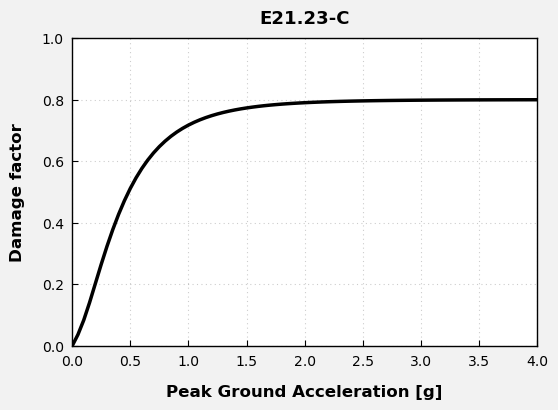

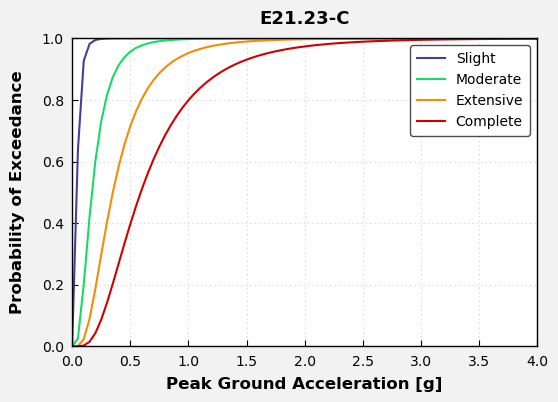

In [50]:
meta = data_utils.get_curve_metadata(ID_number, network)
data_utils.generate_plots(ID_number)

## Example 2: Energy - Windstorms

In [51]:
network = networks[0] # Energy

Select the filtering criteria below to display all available ID numbers that match the chosen sector, hazard, and intensity measure.

In [52]:
styled, raw = data_utils.filter_curves(
    network=network,
    hazard_type="W",
    intensity_metric="3-sec peak gust wind speed at 10 m height",
    cost_feature="Yes",
    geographical_application="Mexico"
)

display(styled)

,ID number,Infrastructure description,Additional characteristics,Characteristics of curve,Fragility and/or vulnerability,Damage states (in case of fragility),Reference
34,W1.1,Wind turbines,"1-MW capacity, 40-m hub height; fixed in the base; blades in feathered position minimizing the drag force",RC,F + V,"3 - 'Residual displacement', 'Yielding of tower', 'Collapse'",Jaimes et al. (2019)
35,W1.2,Wind turbines,"2.5-MW capacity, 80-m hub height; fixed in the base; blades in feathered position minimizing the drag force",RC,F + V,"3 - 'Residual displacement', 'Yielding of tower', 'Collapse'",Jaimes et al. (2019)
36,W1.3,Wind turbines,"3.3-MW capacity, 100-m hub height; fixed in the base; blades in feathered position minimizing the drag force",RC,F + V,"3 - 'Residual displacement', 'Yielding of tower', 'Collapse'",Jaimes et al. (2019)


Choose the appropriate ID_number from the table above to generate the corresponding vulnerability or/and fragility curves.

In [53]:
ID_number = "W1.1"


Curve info :
Hazard Type: W
Intensity Metric: 3-sec peak gust wind speed at 10 m height
Fragility/Vulnerability Type: F + V
Reference: Jaimes et al. (2019)

Intensity Measure Code: V10m
Units: [m/s]

Extracted Damage States: ['Residual displacement', 'Yielding of tower', 'Collapse']
Number of Damage States: 3


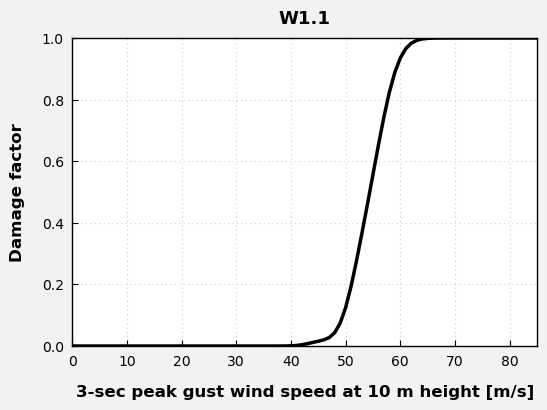

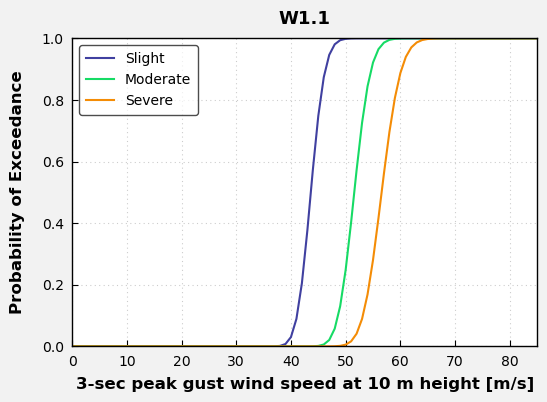

In [54]:
meta = data_utils.get_curve_metadata(ID_number, network)
data_utils.generate_plots(ID_number)